In [1]:
import os

os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/local/cuda/nvvm/libdevice/"
os.environ['NUMBAPRO_NVVM'] = "/usr/local/cuda/nvvm/lib64/libnvvm.so"

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import argparse
import importlib.machinery
# import types
import os
# import pickle
from shapely import wkt, geometry
import json
import numpy as np
from copy import deepcopy
from IPython.core.debugger import set_trace
import sys
sys.path.append("../../ddsl/")

from ddsl import *
from airfoil_NUFT import *

from AFNet import AFNet


import pandas as pd
      
class PolyAirfoils(object):
    def __init__(self, airfoil):
        V,E,_=construct_VED(airfoil, 'cuda', True)
        self.V=V
        self.E=E
        
    def __getitem__(self):
        return self.V, self.E
    
    def get_poly(self):
        P=Polygon(self.V)
        return P


class ShapeOptimizer(object):
    def __init__(self, polygon, C, model, cfd_data, target, device):
        """
        object for optimizing polygonal shapes (MNIST experiment)
        params:
        polygon: shapely Polygon or MultiPolygon object.
        C: shape (#C, 2) control points
        model: trained pytorch model for inference.
        Re: Reynolds number
        target: int. target class to convert to.
        device: pytorch device type
        """
        self.CPoly = CPolygon(polygon, C)
        self.V = self.CPoly.V
        self.E = self.CPoly.E
        self.polygon = [polygon]
        self.D = torch.ones(self.E.shape[0], 1, dtype=torch.float64)
        self.model = model
        self.cfd_data=cfd_data
        self.target_tensor = torch.tensor(target, dtype=torch.float64).view(-1,1).to(device)
        self.dV = None
        self.dC = None
        self.res = 224
        self.profile = {"loss": [],
                        "ClCd": []}
        
    def step(self, step_size=1e-3, sign=-1, stochastic=False):
        '''
        combines _get_grad and _step.
        sign = 1 for maximizing score
        sign = -1 for minimizing score
        '''
        assert(sign==1 or sign==-1)
        self._get_grad()
        self._step(step_size=step_size, sign=sign, stochastic=stochastic)

    def _step(self, step_size=1e-3, sign=-1, stochastic=False):
        """
        Take a step toward gradient direction. 
        params:
        step_size: gradient step size
        sign: 1 or -1, to go maximize or minimize value
        check: bool. whether to enforce no-intersection constraint
        shuffle: whether to traverse points in random order during checked updates
        """
        dC = self.dC.copy()
        if not stochastic:
            dC[:, -1] *= 100
            self.CPoly.update_control(sign * step_size * dC)
        else:
            dC = np.sign(dC)
            dC[:, -1] *= 30
            self.CPoly.update_control(sign * step_size * dC)
        self.V = self.CPoly.V
        self.polygon.append(deepcopy(self.CPoly.polygon))

    def _get_grad(self):
        """
        Compute gradient of loss function w.r.t. into vertices
        params:
        self
        """
        # convert polygon vertices to physical image w/ DDSL
        ddsl_phys=DDSL_phys((224,224),(1,1),2,1)
        self.V=torch.tensor(self.V, dtype=torch.float64, requires_grad=True)
        self.E=torch.LongTensor(self.E)
        f = ddsl_phys(self.V,self.E,self.D)
    
        # compute loss wrt. target class
        self.model = self.model.double()
        self.model.eval()  
        self.model.zero_grad()  
        criterion=nn.MSELoss()
        output=self.model(f, self.cfd_data)  
        loss = criterion(output,self.target_tensor)  
        loss.backward()  
        self.profile['loss'].append(loss.item()) # save loss at current iteration
        self.profile['ClCd'].append(output.item())

        # compute grad on V
        self.dV = self.V.grad.detach().cpu().numpy()
      
        # compute grad on C
        dVdC = self.CPoly.dVdC
        self.dC = np.einsum("ijkl,ij->kl", dVdC, self.dV)       
                
class CPolygon(object):
    def __init__(self, polygon, C):
        self.polygon = polygon
        self.V, self.E, self.E_segs = self.getVE()
        self.npoly = len(self.E_segs)
        self.C = C
        self.W = None # shape (#V, #C)
        self.dVdC = None # shape (#V, 2, #C, 3)
        self._update_weights()
        
    def update_control(self, dC, rad=True):
        """dC: shape (#C, 3), where 3 dims are x, y, theta"""
        assert(self.C.shape[0] == dC.shape[0])
        dtheta = dC[:, 2].copy()
        dC = dC[:, :2].copy()
        if not rad:
            dtheta = dtheta / 180 * np.pi
        Vnew = np.zeros_like(self.V)
        for i in range(dtheta.shape[0]):
            t = dtheta[i]
            Rot = np.array([[np.cos(t), -np.sin(t)],
                            [np.sin(t), np.cos(t)]])
            a, b = self.C[i]
            Rot_trans = np.array([-a*np.cos(t)+b*np.sin(t)+a,
                                  -a*np.sin(t)-b*np.cos(t)+b])
           
            Vnew += self.W[:, i:i+1] * (self.V.dot(Rot.T) + dC[i] + Rot_trans)
        self.V = Vnew # update vertices
        self.C += dC # update control points
        self.polygon = self.newPolygon(self.V) # update polygon
        self._update_weights() # update weights and sensitivity matrix

    def _update_weights(self):
        self.W = np.zeros([self.V.shape[0], self.C.shape[0]])
        for i in range(self.W.shape[0]):
            for j in range(self.W.shape[1]):
                v = self.V[i]
                c = self.C[j]
                self.W[i,j] = 1/(np.linalg.norm(c-v)**2)
        # normalize
        self.W = (self.W.T / np.sum(self.W, axis=1)).T
        # compute sensitivity matrix
        nV = self.V.shape[0]
        nC = self.C.shape[0]
        self.dVdC = np.zeros([nV, 2, nC, 3])
        vx, vy = self.V[:, 0:1], self.V[:, 1:2]
        cx, cy = self.C[:, 0], self.C[:, 1]
        # d vx / d cx
        self.dVdC[:, 0, :, 0] = self.W
        # d vy / d cy
        self.dVdC[:, 1, :, 1] = self.W
        # d vx / d ctheta
        self.dVdC[:, 0, :, 2] = self.W * (-vy+cy)
        # d vy / d ctheta
        self.dVdC[:, 1, :, 2] = self.W * (vx-cx)
        
        
    def edgeList(self, startid, length, flip=False):
        # helper function to create edge list
        p1 = np.arange(startid, startid+length)
        p2 = p1 + 1
        p2[-1] = startid
        if not flip:
            return np.stack((p1, p2), axis=-1)
        else:
            return np.flipud(np.stack((p2, p1), axis=-1))
        
    def singlePolygon(self, P):
        # helper function for processing a single polygon instance
        assert(isinstance(P, geometry.polygon.Polygon))
        v = []
        e = []
        ecount = 0
        # exterior
        v_ex = np.array(P.exterior)[:-1]
        e_ex = self.edgeList(0, v_ex.shape[0])
        v.append(v_ex)
        e.append(e_ex)
        ecount += v_ex.shape[0]
        # interiors
        for int_ in P.interiors:
            v_in = np.array(int_)
            e_in = self.edgeList(ecount, v_in.shape[0], flip=False)
            v.append(v_in)
            e.append(e_in)
            ecount += v_in.shape[0]
        v = np.concatenate(v, axis=0)
        e_segs = e
        e = np.concatenate(e, axis=0)
        if not P.exterior.is_ccw:
            e = np.concatenate([e[:, 1:2], e[:, 0:1]], axis=-1) # flip e
        return v, e, e_segs
    
    def getVE(self):
        E_segs = []
        if isinstance(self.polygon, geometry.polygon.Polygon):
            V, E, e_segs = self.singlePolygon(self.polygon)
            E_segs.append(e_segs)
        elif isinstance(self.polygon, geometry.multipolygon.MultiPolygon):
            V = []
            E = []
            E_segs = []
            ecount = 0
            for P in self.polygon.geoms:
                v, e, e_segs = self.singlePolygon(P)
                V.append(v)
                E.append(e+ecount)
                for s in e_segs:
                    s += ecount
                E_segs.append(e_segs)
                ecount += v.shape[0]
            V = np.concatenate(V, axis=0)
            E = np.concatenate(E, axis=0)
        
        return V, E, E_segs
    
    def newPolygon(self, V):
        np.testing.assert_array_equal(V.shape, self.V.shape)
        polys = []
        for loops in self.E_segs:
            # exterior loop
            ext_loop = loops[0][:, 0]
            ext_v = geometry.asLinearRing(V[ext_loop])
            ints_v = []
            for i in range(1, len(loops)):
                int_loop = loops[i][:, 0]
                int_v = geometry.asLinearRing(V[int_loop])
                ints_v.append(int_v)
            poly = geometry.Polygon(ext_v, ints_v)
            polys.append(poly)
        if len(polys) == 1:
            return polys[0]
        else:
            return geometry.MultiPolygon(polys)
            

In [4]:
from matplotlib import pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from numpy import asarray, concatenate, ones
from shapely.geometry import *

def ring_coding(ob):
    # The codes will be all "LINETO" commands, except for "MOVETO"s at the
    # beginning of each subpath
    n = len(ob.coords)
    codes = ones(n, dtype=Path.code_type) * Path.LINETO
    codes[0] = Path.MOVETO
    return codes

def pathify(polygon):
    # Convert coordinates to path vertices. Objects produced by Shapely's
    # analytic methods have the proper coordinate order, no need to sort.
    vertices = concatenate(
                    [asarray(polygon.exterior)]
                    + [asarray(r) for r in polygon.interiors])
    codes = concatenate(
                [ring_coding(polygon.exterior)]
                + [ring_coding(r) for r in polygon.interiors])
    return Path(vertices, codes)

def showPolygon(polygon):
    fig = plt.figure(num=1, figsize=(4, 4))
    ax = fig.add_subplot(111)

    path = pathify(polygon)
    patch = PathPatch(path, facecolor='#339966', edgecolor='#999999')

    ax.add_patch(patch)

    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_aspect(1.0)
    
    return fig, ax    

In [5]:
# Load CFD datafiles
filepath='processed_data'
df=pd.read_csv(os.path.join(filepath, 'airfoil_data_normalized.csv')).drop(columns=['Unnamed: 0'])
df_orig=pd.read_csv(os.path.join(filepath, 'airfoil_data.csv')).drop(columns=['Unnamed: 0'])
stats=pd.read_csv(os.path.join(filepath, 'airfoil_data_mean_std.csv')).drop(columns=['Unnamed: 0'])
mean=stats['mean']
std=stats['std']

In [11]:
# parse arguments
parser = argparse.ArgumentParser(description='MNIST shape optimization')
parser.add_argument('-r', '--Re', type=float, default=1e6, help='Reynolds number of flow')
parser.add_argument('-a', '--aoa', type=float, default=0, help='airfoil angle of attack')
parser.add_argument('-c', '--C', type=str, default='example.txt', help='control points text file (default:example.txt)')
# parser.add_argument('--save_path', type=str, help='save file path', required=True)
parser.add_argument('-t','--save_shape_as_txt', type=bool, default=False, help='save coordinates of shapes in each iteration as text files (default: False)')
parser.add_argument('-l', '--logdir', type=str, default="log_01-26-2019_10-07-23", help='log directory path')
parser.add_argument('-s', '--step_size', type=float, default=1e-3, help='step size for shape optimization')
parser.add_argument('--no_cuda', action='store_true', help='do not use cuda')
parser.add_argument('--seed', type=int, default=1, metavar='S', help='random seed (default: 1)')

args = parser.parse_args('')

use_cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")

# Load the model
model=AFNet(bottleneck=1000)
if use_cuda:
    model = nn.DataParallel(model)
model.to(device)
state=torch.load(os.path.join(args.logdir,"AFNet_model.checkpoint"))
model.load_state_dict(state['model'])
optimizer=torch.optim.Adam(model.parameters())
optimizer.load_state_dict(state['optim'])

# Shape Optimization
pairfoils = PolyAirfoils('n0012')
P = pairfoils.get_poly()
C = np.loadtxt(args.C)

Re=1e6
aoa=0
Re_in=torch.tensor((Re-mean[1])/std[1], dtype=torch.float64).view(-1,1)
aoa_in=torch.tensor((aoa-mean[0])/std[0], dtype=torch.float64).view(-1,1)
cfd_data=torch.cat((Re_in, aoa_in), 1)

optim = ShapeOptimizer(P, C, model, cfd_data=cfd_data, target=2.0, device=device)

In [12]:
args

Namespace(C='example.txt', Re=1000000.0, aoa=0, logdir='log_01-26-2019_10-07-23', no_cuda=False, save_shape_as_txt=False, seed=1, step_size=0.001)

In [12]:
%matplotlib inline

from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation, rc

savefile='optim/optim_test2'

fig, ax = showPolygon(optim.polygon[-1])
plt.close()

def update(frame_number,step_size):
    if frame_number > 0:
        optim.step(step_size, sign=-1, stochastic=False)   
    path = pathify(optim.polygon[-1])
    patch = PathPatch(path, facecolor='#339966', edgecolor='#999999')
    ax.cla()
    ax.add_patch(patch)
    if frame_number > 0:
        ClCd=optim.profile['ClCd'][-1]*std[4]+mean[4]
        title = "Iter: {}, Loss: {:_<6f}, Pred: {:_<6f}".format(frame_number, optim.profile['loss'][-1], ClCd)
        x,y=optim.polygon[-1].exterior.xy
        if args.save_shape_as_txt:
            np.savetxt(savefile+str(frame_number).zfill(3)+'.txt',pd.DataFrame([x,y]).transpose().values)
    else:
        title = "Iter: {0}".format(frame_number)
    ax.set_title(title)
    print(title)
anim = animation.FuncAnimation(fig, update, interval=100, frames=10, fargs=[4e-5])

# save animation
Writer = animation.writers['ffmpeg']
writer = Writer(fps=5, bitrate=1800)
anim.save(savefile+'.mp4', writer=writer)

# save loss and pred
pd.DataFrame(optim.profile).to_csv(savefile+'.csv')


Iter: 0
Iter: 0
Iter: 1, Loss: 0.451143, Pred: 71.018982
Iter: 2, Loss: 0.284175, Pred: 76.154285
Iter: 3, Loss: 0.336328, Pred: 74.418060
Iter: 4, Loss: 0.241201, Pred: 77.709009
Iter: 5, Loss: 0.239401, Pred: 77.777031
Iter: 6, Loss: 0.175044, Pred: 80.404262
Iter: 7, Loss: 0.144177, Pred: 81.837344
Iter: 8, Loss: 0.091650, Pred: 84.689365
Iter: 9, Loss: 0.079750, Pred: 85.442920


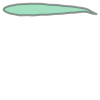

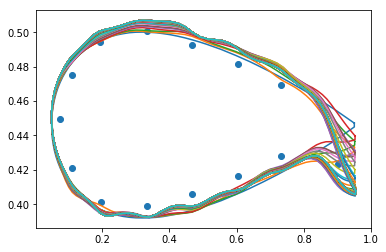

In [18]:
for i in range(0,len(optim.polygon)):
  x,y=optim.polygon[i].exterior.xy
  plt.plot(x,y)
plt.scatter(C[:,0], C[:,1])
# plt.ylim([0,1])
# plt.xlim([0,1])
optim.polygon[-1]

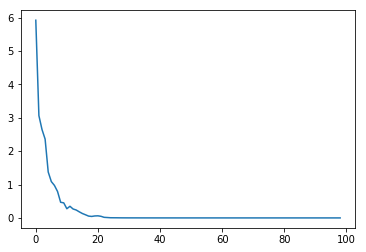

In [17]:
start=0
plt.plot(optim.profile['loss'][start:])
# plt.plot(optim.profile['ClCd'][start:])